In [ ]:
#correcion de prediccion palabra ambigua
#fusionar los dos archivos

#  Importar librerías
import pandas as pd

# Cargar archivos
df_palabras = pd.read_csv("/content/top_300_ambiguas_completo.csv")
df_frases = pd.read_csv("/content/frases_traducidas_500.csv")

# Unir por palabra ambigua (palabra/frase)
df_merged = pd.merge(df_frases, df_palabras[["Palabra", "Significados_es"]],
                     left_on="palabra", right_on="Palabra", how="left")

# Eliminar la columna duplicada 'Palabra' del diccionario
df_merged.drop(columns=["Palabra"], inplace=True)

# Eliminar filas que NO tengan traducción o lista de significados
df_merged = df_merged.dropna(subset=["traduccion_es", "Significados_es"])

# Eliminar filas con lista de significados vacía
df_merged = df_merged[df_merged["Significados_es"].str.strip() != ""]

# Mostrar cuántas frases útiles quedaron
print(f"Frases útiles después de limpiar: {df_merged.shape[0]}")
df_merged.head()


print(f"Frases útiles para etiquetar: {df_merged.shape[0]}")
df_merged.head()

# Verificar fusión
print(df_merged.shape)
print(df_merged.columns)
df_merged.head()

Frases útiles después de limpiar: 495
Frases útiles para etiquetar: 495
(495, 5)
Index(['frase', 'palabra', 'significado_correcto', 'traduccion_es',
       'Significados_es'],
      dtype='object')


,frase,palabra,significado_correcto,traduccion_es,Significados_es
0,薛偏要在床上看电视,看,NaN,Xue quiere ver la tele en la cama.,para ver; mirar; para leer; para mirar; para v...
1,回答問題。,回,NaN,Responde a la pregunta.,a un círculo; volver; dar la vuelta; para resp...
2,你知道这儿附近有什么好餐馆吗?,道,NaN,¿Conoces algún buen restaurante por aquí?,"camino; ruta (cl: 條 | 条 [tiao2], 股 [gu3]); (fo..."
3,在你有需要的時候，會幫你的朋友才是真正的朋友。,有,NaN,Un amigo que te ayuda cuando lo necesitas es u...,tener; hay; (forma unida) tener; con; -ful; -E...
4,我们是学生。,生,NaN,Somos estudiantes.,nacer; dar a luz; vida; crecer; crudo; crudo; ...


In [4]:
#guardamos frases fusionadas
df_merged.to_csv("frases_fusionadas.csv", index=False)

In [5]:
#etiquetado semantico
# Instalar spaCy y el modelo en español
!pip install -U spacy
!python -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 14.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
import spacy
from tqdm import tqdm

# Cargar el modelo de español
nlp = spacy.load("es_core_news_md")
tqdm.pandas()

In [7]:
# Función para seleccionar el significado más similar a la traducción
def predecir_significado(fila):
    if pd.isna(fila["Significados_es"]) or pd.isna(fila["traduccion_es"]):
        return "NO_DISPONIBLE"

    # Separar significados como lista
    significados = [s.strip() for s in fila["Significados_es"].split(";") if s.strip()]
    if not significados:
        return "SIN_SIGNIFICADOS"

    # Comparar con traducción
    doc_trad = nlp(fila["traduccion_es"])
    max_score = 0
    mejor_significado = "NO_DETECTADO"

    for sig in significados:
        doc_sig = nlp(sig)
        score = doc_trad.similarity(doc_sig)
        if score > max_score:
            max_score = score
            mejor_significado = sig

    return mejor_significado

In [ ]:
#aplicar la funcion al dataset

In [8]:
df_merged["significado_predicho"] = df_merged.progress_apply(predecir_significado, axis=1)

  1%|          | 4/495 [00:00<00:58,  8.45it/s]<ipython-input-7-7d7089b48f94>:18: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  score = doc_trad.similarity(doc_sig)
100%|██████████| 495/495 [00:33<00:00, 14.60it/s]


In [9]:
df_merged.to_csv("frases_etiquetadas_corregidas.csv", index=False)
print(" Archivo guardado como frases_etiquetadas_corregidas.csv")

 Archivo guardado como frases_etiquetadas_corregidas.csv


In [10]:
#entrenamos el modelo con el nuevo data set
#objetivo es entrenar un modelo que, dada una frase y una palabra ambigua, prediga el significado correcto en contexto.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [ ]:
# Cargar el archivo limpio y etiquetado
df = pd.read_csv("frases_etiquetadas_corregidas.csv")

# Usamos solo las columnas necesarias
df = df[["frase", "palabra", "significado_predicho"]].dropna()

In [13]:
#Combinamos la frase completa con la palabra ambigua marcada explícitamente con el texto [PALABRA]
#para que el modelo sepa que palabra estamos desambiguando
df["input_text"] = df["frase"] + " [PALABRA] " + df["palabra"]

In [14]:
# Convertimos texto a vectores numéricos
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df["input_text"])

# Variable objetivo
y = df["significado_predicho"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
#entrenamiento
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [17]:
#evaluamos el rendimiento del modelo
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                                                                                                                                        precision    recall  f1-score   support

                                                                                                                                                                 (de agua, etc.) claro       0.00      0.00      0.00         1
                                                                                                                                                                    (de ninguna manera       0.00      0.00      0.00         4
                                                                                                                     (seguido de un sustantivo y adjetivo) más {adj.} que {sustantivo}       0.00      0.00      0.00         1
                                                                                                       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#predice mal. asi que cargamos en dataset y vemos las 20 clase mas frecuentes

In [18]:
import pandas as pd

# Cargar archivo
df = pd.read_csv("/content/frases_etiquetadas_corregidas.csv")

# Asegurar que las columnas estén bien y eliminar nulos
df = df[["frase", "palabra", "significado_predicho"]].dropna()

# Ver las 20 clases más frecuentes
top_clases = df["significado_predicho"].value_counts().nlargest(20)
print(top_clases)

significado_predicho
para terminar                                                    25
tener                                                            21
tan pronto como                                                  16
verdadero                                                        14
con                                                              14
(Reconocimiento respetuoso de un comando) muy bien               13
(de ninguna manera                                               12
a lo largo de                                                     9
todo                                                              7
querer                                                            7
mirar                                                             6
bien                                                              6
completamente (no)                                                6
razón                                                             6
necesitar                  

In [19]:
# Filtrar el dataset solo con las clases más comunes
df_filtrado = df[df["significado_predicho"].isin(top_clases.index)].copy()

# Crear texto de entrada combinando frase + palabra ambigua
df_filtrado["input_text"] = df_filtrado["frase"] + " [PALABRA] " + df_filtrado["palabra"]

# Verificar
df_filtrado.head()

,frase,palabra,significado_predicho,input_text
2,你知道这儿附近有什么好餐馆吗?,道,razón,你知道这儿附近有什么好餐馆吗? [PALABRA] 道
3,在你有需要的時候，會幫你的朋友才是真正的朋友。,有,tener,在你有需要的時候，會幫你的朋友才是真正的朋友。 [PALABRA] 有
8,他们不是公司员工吗？,是,verdadero,他们不是公司员工吗？ [PALABRA] 是
10,你看上去很傻。,看,mirar,你看上去很傻。 [PALABRA] 看
13,可能要下雨了。,要,necesitar,可能要下雨了。 [PALABRA] 要


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Vectorizar texto con TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df_filtrado["input_text"])
y = df_filtrado["significado_predicho"]

# División entrenamiento/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

                                                    precision    recall  f1-score   support

(Reconocimiento respetuoso de un comando) muy bien       0.00      0.00      0.00       2.0
                                (de ninguna manera       0.00      0.00      0.00       3.0
                                     a lo largo de       0.00      0.00      0.00       2.0
                                              bien       0.00      0.00      0.00       2.0
                                completamente (no)       0.00      0.00      0.00       2.0
                                               con       0.00      0.00      0.00       5.0
                                            el más       0.00      0.00      0.00       3.0
                                             lugar       0.00      0.00      0.00       1.0
                                         necesitar       0.00      0.00      0.00       1.0
                                     para terminar       0.00      0.00      0.

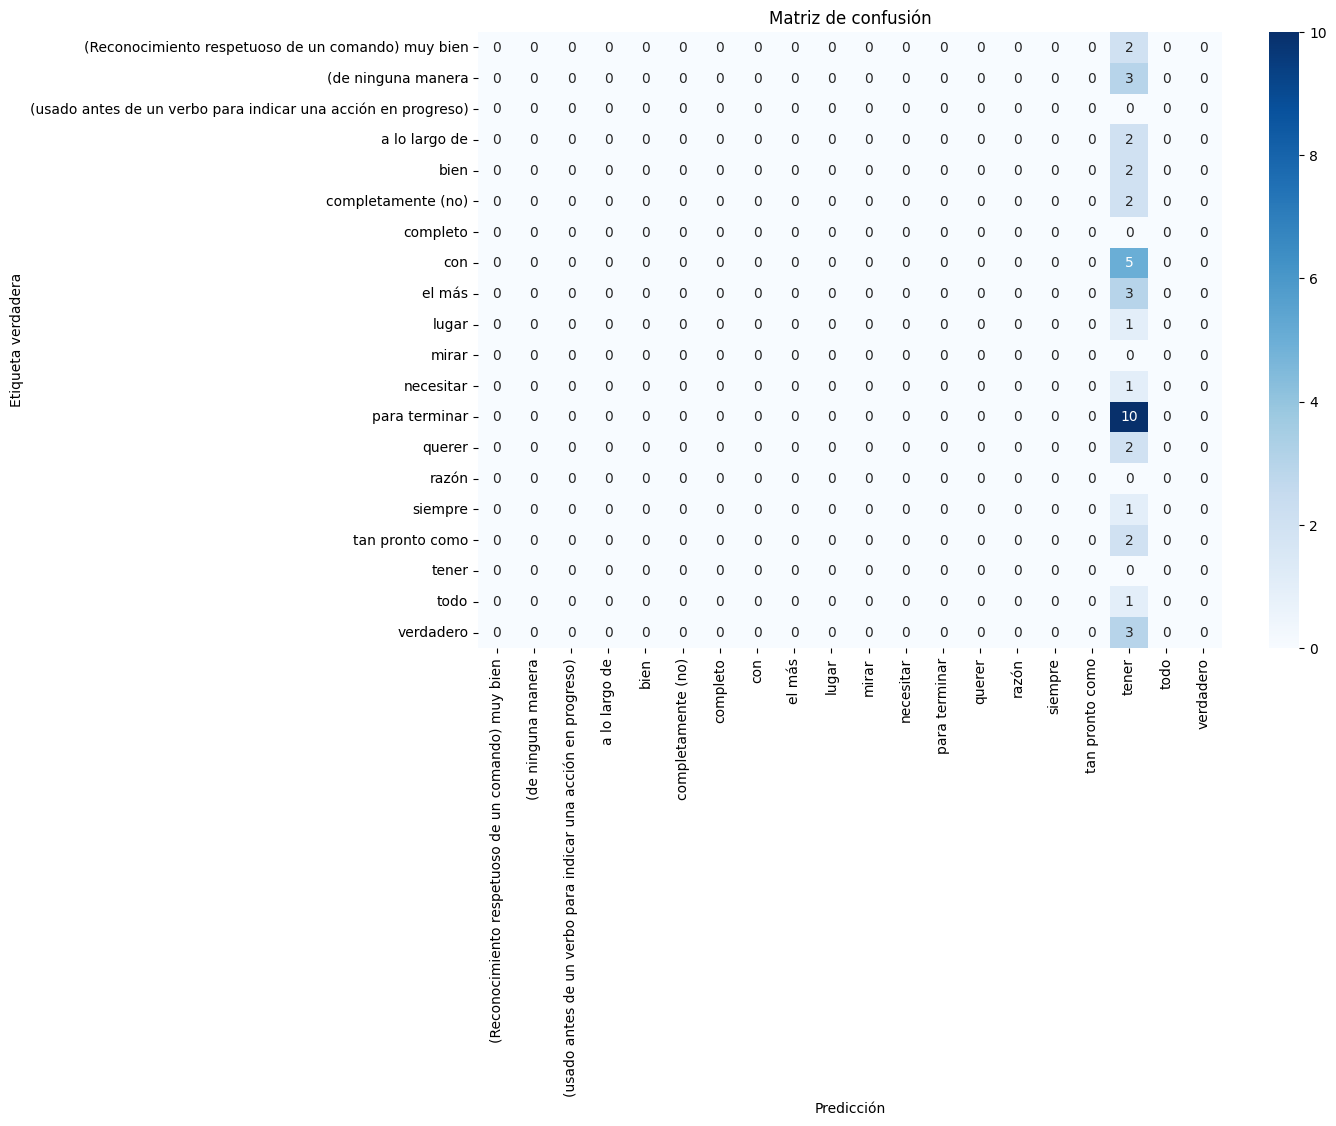

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicciones
y_pred = clf.predict(X_test)

# Reporte de métricas
print(classification_report(y_test, y_pred))

# (opcional) Matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_, cmap="Blues")
plt.title("Matriz de confusión")
plt.ylabel("Etiqueta verdadera")
plt.xlabel("Predicción")
plt.show()

In [22]:
#tampoco predeci bien asi que vamos a utilizar un modelo mas complejo
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [23]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Usar modelo multilingüe optimizado
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Codificar frases
X = model.encode(df_filtrado["input_text"].tolist())
y = df_filtrado["significado_predicho"].tolist()

# Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluar
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

                                                    precision    recall  f1-score   support

(Reconocimiento respetuoso de un comando) muy bien       1.00      1.00      1.00         2
                                (de ninguna manera       0.00      0.00      0.00         3
                                     a lo largo de       0.00      0.00      0.00         2
                                              bien       0.00      0.00      0.00         2
                                completamente (no)       0.00      0.00      0.00         2
                                               con       0.00      0.00      0.00         5
                                            el más       0.00      0.00      0.00         3
                                             lugar       0.00      0.00      0.00         1
                                         necesitar       0.00      0.00      0.00         1
                                     para terminar       0.55      0.60      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [24]:
#intentar mejoras
# Filtrar clases con al menos 8 ejemplos
top_classes = df["significado_predicho"].value_counts()
clases_validas = top_classes[top_classes >= 8].index
df_filtrado = df[df["significado_predicho"].isin(clases_validas)].copy()

# Crear input_text de nuevo (si no lo tenías hecho)
df_filtrado["input_text"] = df_filtrado["frase"] + " [PALABRA] " + df_filtrado["palabra"]

# Ver clases seleccionadas
print(df_filtrado["significado_predicho"].value_counts())

significado_predicho
para terminar                                         25
tener                                                 21
tan pronto como                                       16
verdadero                                             14
con                                                   14
(Reconocimiento respetuoso de un comando) muy bien    13
(de ninguna manera                                    12
a lo largo de                                          9
Name: count, dtype: int64


In [25]:
# Crear columna agrupada
def agrupar_significado(texto):
    if "terminar" in texto:
        return "acción_final"
    elif "muy bien" in texto or "bien" in texto:
        return "aprobación"
    elif "de ninguna manera" in texto or "completamente (no)" in texto:
        return "negación"
    elif "con" in texto or "a lo largo de" in texto:
        return "relación"
    elif "el más" in texto or "tan pronto como" in texto:
        return "comparación"
    elif "querer" in texto or "necesitar" in texto:
        return "intención"
    elif "siempre" in texto or "todo" in texto:
        return "generalidad"
    elif "verdadero" in texto:
        return "veracidad"
    else:
        return "otros"

# Aplicar agrupación
df["significado_agrupado"] = df["significado_predicho"].apply(agrupar_significado)

# Filtrar para entrenar solo con agrupados
df_filtrado = df[df["significado_agrupado"] != "otros"].copy()
df_filtrado["input_text"] = df_filtrado["frase"] + " [PALABRA] " + df_filtrado["palabra"]

# Ver conteo
print(df_filtrado["significado_agrupado"].value_counts())

significado_agrupado
relación        41
acción_final    25
comparación     22
aprobación      21
negación        18
veracidad       14
intención       13
generalidad     13
Name: count, dtype: int64


In [26]:
y = df_filtrado["significado_predicho"]  # para opción A
y = df_filtrado["significado_agrupado"]  # para opción B

In [29]:
# Guardar el dataset final
df_filtrado.to_csv("dataset_entrenamiento_final.csv", index=False)

In [30]:
from google.colab import files
files.download("dataset_entrenamiento_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
!pip install -U sentence-transformers

In [31]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Usar modelo multilingüe optimizado
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Codificar frases
X = model.encode(df_filtrado["input_text"].tolist())
y = df_filtrado["significado_predicho"].tolist()

# Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluar
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                                                                                      precision    recall  f1-score   support

                                                                                  (Reconocimiento respetuoso de un comando) muy bien       0.00      0.00      0.00         1
                                                                                                                  (de ninguna manera       0.00      0.00      0.00         3
(utilizado con 得 [DE2] o 不 [Bu4] después de un verbo para expresar (im) posibilidad, como en 忘不了 [wang4bu5liao3] "no puede olvidar")       0.00      0.00      0.00         1
                                                                                                                       a lo largo de       0.00      0.00      0.00         2
                                                                                                                                b

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Ha mejorado un poco.